In [1]:
import matplotlib.pyplot as plt

from copy import deepcopy
import numpy as np
from random import choice
import math

from Hallway import Hallway, Options

from helpers import render_V, filter_space, e_greedy, get_q_table

In [2]:
def value_iteration(options_to_iterate='all', goal=(9,9)):

    hall = Hallway((1,1), goal)
    
    if options_to_iterate == 'all':
        search_space = set(hall.primitive_options + hall.multistep_options)
    elif options_to_iterate == 'primitive-only':
        search_space = set(hall.primitive_options)
    elif options_to_iterate == 'multistep-only':
        search_space = set(hall.multistep_options)
    else:
        raise Exception('Please use on of "all", "primitive-only", "multistep-only"')

    V = { s: 0.0 for s in hall._states }
    V[goal] = 1.0

    theta = 0.01
    p = hall.get_prob_distro()
    # Value Iteration
    Lambda = 1

    all_V= []
    #for _ in range(10):
    while Lambda > theta:
        Lambda = 0
        V_copy = deepcopy(V)
        for s in hall._states:
            v = V[s]

            max_o = 0
            for o in search_space.intersection(p[s].keys()):
                for s_next, po_s_s_next in p[s][o].items():
                    r = 1.0 if s == goal else 0.0
                    k = abs(s_next[0] - s[0]) + abs(s_next[1] - s[1])
                    o_v = po_s_s_next * (r  + (0.9 ** k) * V[s_next])
                    if o_v > max_o:
                        max_o = o_v

            V_copy[s] = max_o
            Lambda = max(Lambda, abs(v - V_copy[s]))
        all_V.append(deepcopy(V))
        V = V_copy

    return all_V

In [3]:
vs_primitive = value_iteration('primitive-only', (7,9))
vs_multistep = value_iteration('multistep-only', (7,9))
vs_all = value_iteration()

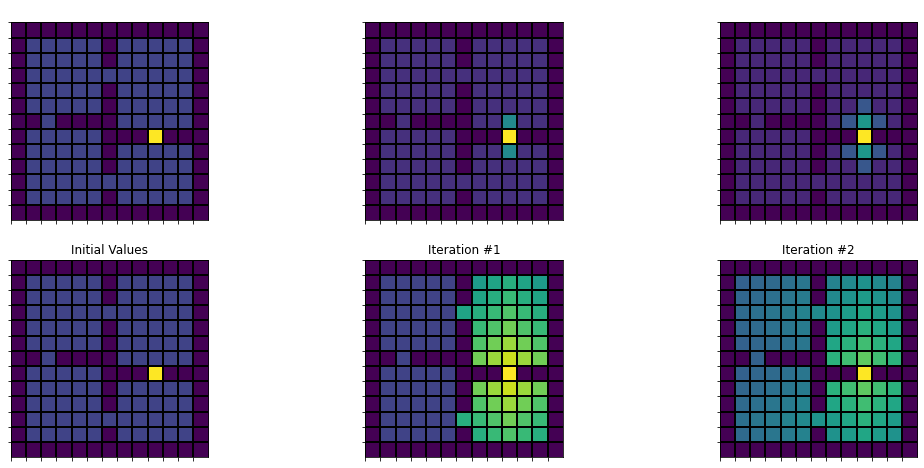

In [4]:
%matplotlib inline

fig, axs = plt.subplots(2,3, figsize=(18,8 ))

render_V(axs[0,0], vs_primitive[0], ' ')
render_V(axs[0,1], vs_primitive[1], ' ')
render_V(axs[0,2], vs_primitive[2], ' ')

render_V(axs[1,0], vs_multistep[0], 'Initial Values')
render_V(axs[1,1], vs_multistep[1], 'Iteration #1')
render_V(axs[1,2], vs_multistep[2], 'Iteration #2')

plt.show()

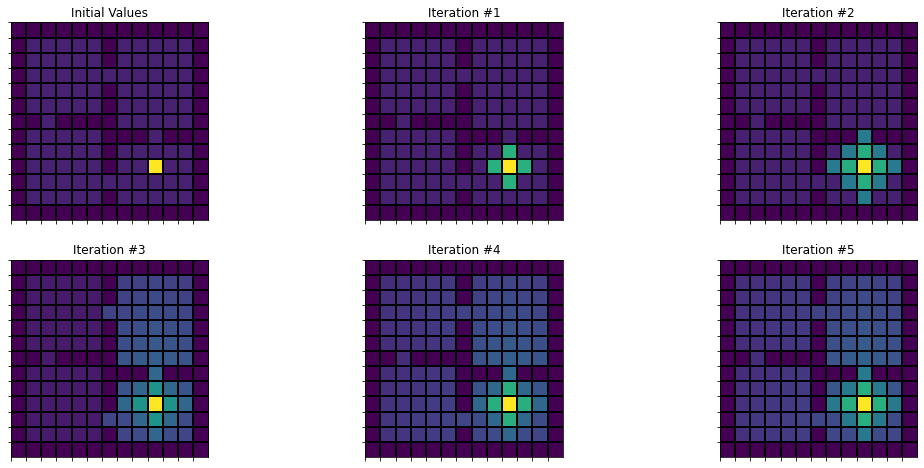

In [5]:
fig, axs = plt.subplots(2,3, figsize=(18,8 ))

render_V(axs[0,0], vs_all[0], 'Initial Values', factor=10)
render_V(axs[0,1], vs_all[1], 'Iteration #1', factor=10)
render_V(axs[0,2], vs_all[2], 'Iteration #2', factor=10)

render_V(axs[1,0], vs_all[3], 'Iteration #3', factor=10)
render_V(axs[1,1], vs_all[4], 'Iteration #4', factor=10)
render_V(axs[1,2], vs_all[5], 'Iteration #5', factor=10)

plt.show()

In [6]:
def q_learning(options_to_iterate='all', goal=(7,9), alpha = 1./8.):
    hall = Hallway((1,1), goal)

    if options_to_iterate == 'all':
        search_space = set(hall.primitive_options + hall.multistep_options)
    elif options_to_iterate == 'primitive-only':
        search_space = set(hall.primitive_options)
    elif options_to_iterate == 'multistep-only':
        search_space = set(hall.multistep_options)
    else:
        raise Exception('Please use on of "all", "primitive-only", "multistep-only"')

    times = []
    for smooth_factor in range(50):
        Q = get_q_table(search_space, hall.primitive_options, hall._states, options_to_iterate)
        time = []
        for episode in range(1000):
            hall = Hallway((1,1), goal)
            s = tuple(hall._current_state)
            done = False
            step_counter = 0
            while not done:
                #print(s)
                o = e_greedy(Q[s], 0.1)

                next_state, r, k, done = hall.step(o)
                
                maxQ = max([value for value in Q[next_state].values()])

                Q[s][o] = Q[s][o] + alpha * (r + (0.9**k)*maxQ - Q[s][o])
                s = next_state

                step_counter += k
            time.append(step_counter)
        times.append(np.array(time))
    times = np.array(times)
    return times, Q

In [7]:
times1,Q1 = q_learning('primitive-only')
times2,Q2 = q_learning('multistep-only', alpha=1./16.)
times3,Q3 = q_learning('all')

In [8]:
times4,Q4 = q_learning('primitive-only', goal=(9,9))
times5,Q5 = q_learning('multistep-only', goal=(9,9))
times6,Q6 = q_learning('all', goal=(9,9), alpha = 1./4.)

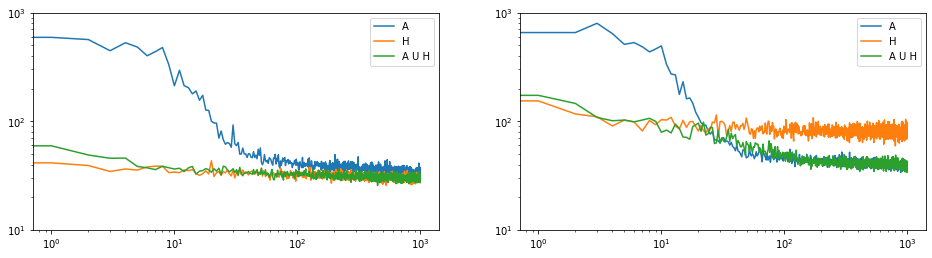

In [9]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 4))
ax0.set_xscale('log')
ax0.set_yscale('log')

ax1.set_xscale('log')
ax1.set_yscale('log')

ax0.set_ylim((10,1000))
ax1.set_ylim((10,1000))

line01, = ax0.plot(times1.mean(0))
line02, = ax0.plot(times2.mean(0))
line03, = ax0.plot(times3.mean(0))

line11, = ax1.plot(times4.mean(0))
line12, = ax1.plot(times5.mean(0))
line13, = ax1.plot(times6.mean(0))

ax0.legend([line01, line02, line03], ['A', 'H', 'A U H'])
ax1.legend([line11, line12, line13], ['A', 'H', 'A U H'])

plt.show()